FedAvg1.0_M1000,10_K20_R10000,50_wvgg9k4_cinic10_exdirb1,100.0_sgd0.1,0.0,0.0_exp1.0_b20_seed0_clip10
CWT_M1000,10_K20_R10000,50_wvgg9k4_cinic10_exdirb1,100.0_sgd0.00316,0.0,0.0_exp1.0_b20_seed0_clip50
 (PFL):    0.7644  (SFL):    0.5946 
 (PFL):     73.76  (SFL):     81.17 
 (PFL):    1.4933  (SFL):    1.6191 
 (PFL):     60.54  (SFL):     66.09 
2024-11-12_09-18-17.png


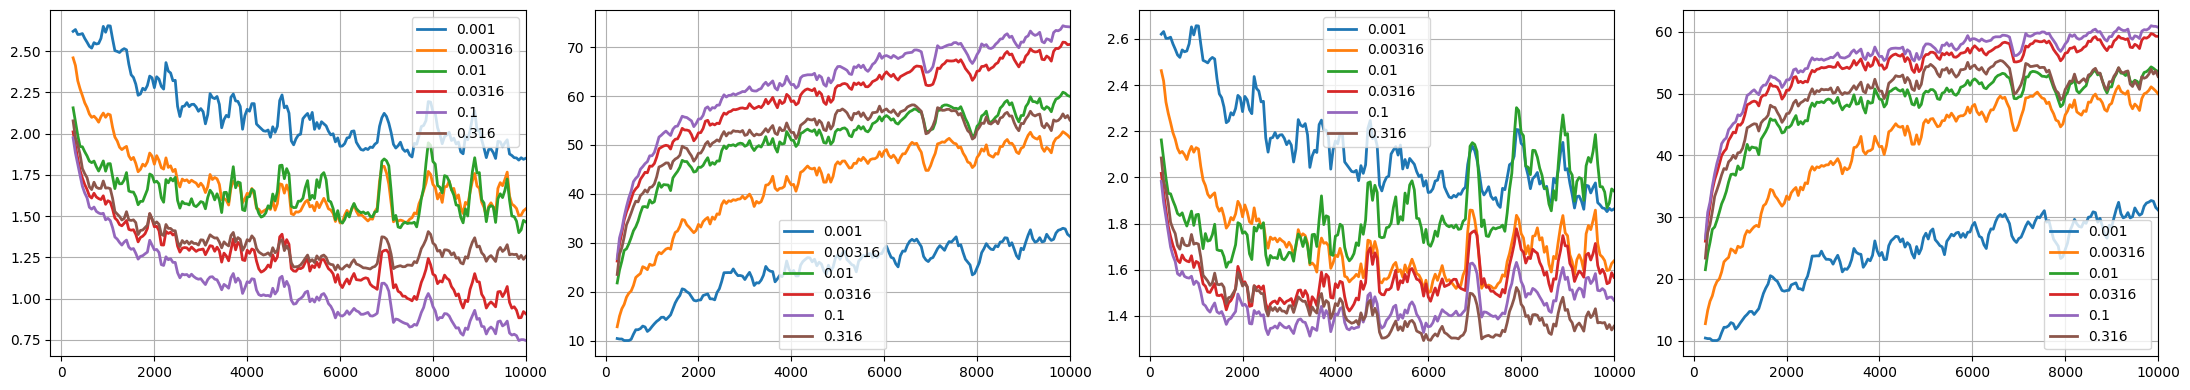

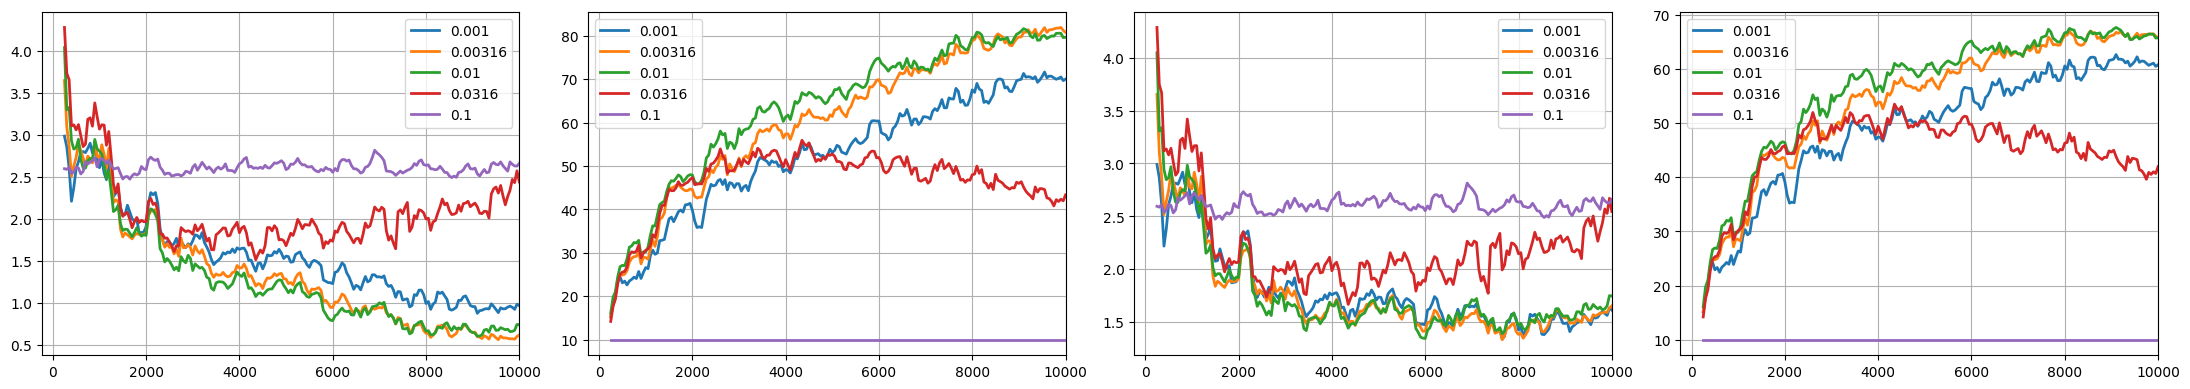

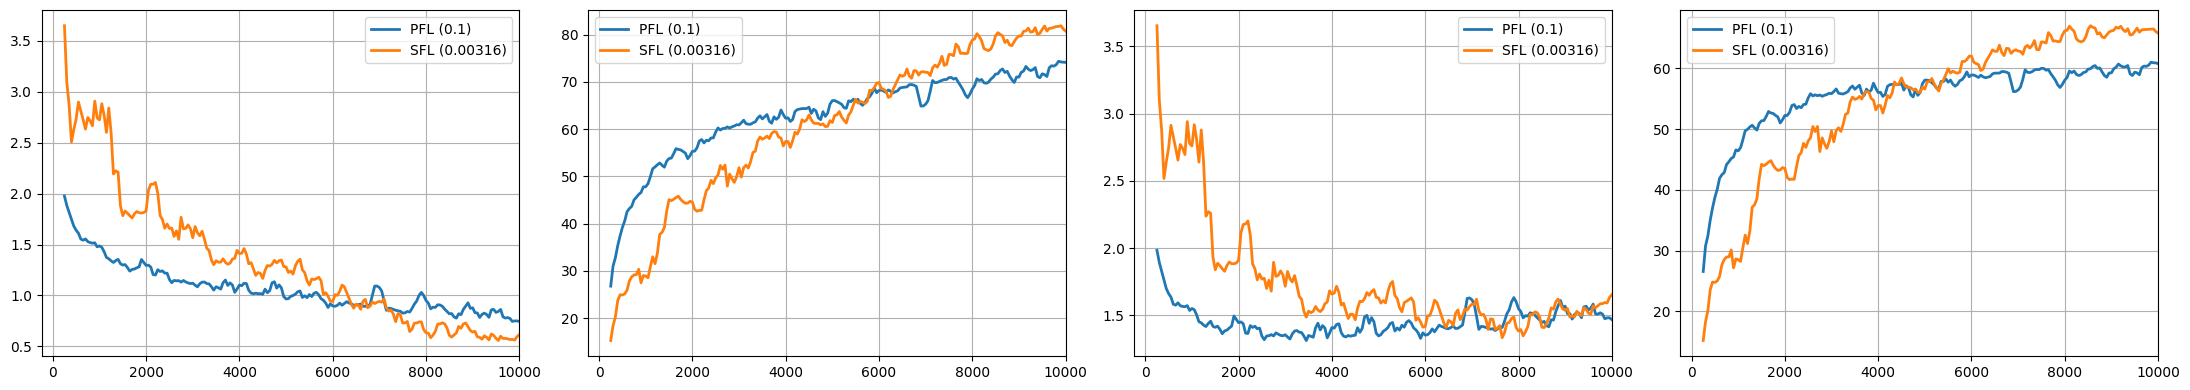

In [19]:
import sys 
sys.path.append("/home/moon/data/exps/SFL/")

import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sim.utils.record_utils import read_fromcsv
from plots.plot_utils import grid_search, moving_average, save_fig_timestamp
import itertools
from types import SimpleNamespace


Algs = ['PFL', 'SFL']

args, search_setup, path = None, None, None


def plot_curve(ax, files, setup, path):
    global args
    for i,file in enumerate(files):
        # if not os.path.exists("{}/{}".format(path, file)):
        #     #print(file)
        #     continue
        df = read_fromcsv(file, path)
        #step = df['round'].values[1] - df['round'].values[0]
        x = df['round'].values
        y = df.iloc[:, setup['y']].values

        if setup['out'] == 1:
            out = df  
            #out = out[df['round'] <= 5000]
            out = out.iloc[:, setup['y']].values[-10:]
            print('{:>6}:'.format('('+str(Algs[i])+')'), end=' ')
            if setup['y'] == 1 or setup['y'] == 4:
                print('{:>9.4f}'.format(out.mean(axis=0)), end=' ')
            else:
                print('{:>9.2f}'.format(out.mean(axis=0)), end=' ')
        
        if setup['smooth'] == 1:
            y_smooth = moving_average(y, 5) # 10
            # adjust the length of the smooth data
            # discard `len(data)- (len(data)-len(windows)+1)=len(windows)-1` data points
            x_smooth = x[len(x)-len(y_smooth):]
            x,y = x_smooth, y_smooth
            
        ax.plot(x, y, lw=2, linestyle='-', label=setup['label'][i])
        ax.set_xlim(xmax=args.R)
    # if setup['y'] == 1:
    #     ax.set_yscale('log')
    #ax.legend(loc=1, ncol= 2, prop={'size': 16})
    ax.legend()
    ax.grid()


def plot_diff(ax, files, setup, path):
    
    y_contents = []
    for file in files:
        df = read_fromcsv(file, path)
        #step = df['round'].values[1] - df['round'].values[0]
        x_axis = df['round'].values
        y_content = df.iloc[:, setup['y']].values
        y_contents.append(y_content)

    diff = y_contents[1] - y_contents[0]
    #print(diff[-10:].mean())
    ax.bar(x_axis, diff, width=20, color='C0', alpha=0.8)




def filter_func(file, curr_value):
    if curr_value <= 10.0:
        return 1
    else:
        return 0

def filter_func2(file, curr_value):
    return 0

def cmp_func(curr_value, best_value):
    if best_value == 0:
        return 1
    if curr_value > best_value:
        return 1
    
def cmp_func2(curr_value, best_value):
    if best_value == 0:
        return 1
    if curr_value < best_value:
        return 1

def main():
    global args, search_setup, path
    args1 = {
    'M': [args.M],
    'P': [args.P],
    'K': [args.K],
    'R': [args.R],
    'eval_every': [args.eval_every],
    'model': [args.model],
    'dataset': [args.dataset],
    'partition': [args.partition],
    'exdir': [args.exdir],
    'exdir2': [args.exdir2],
    'lr': [0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316],
    #'lr': [0.001, 0.01, 0.1],
    #'lr': [0.00316, 0.01, 0.0316, 0.1, 0.316],
    #'lr': [0.000316, 0.001, 0.00316, 0.01, 0.0316, 0.1],
    #'lr': [0.001, 0.00316, 0.01, 0.0316, 0.1],
    #'lr': [0.1],
    'momentum': [args.momentum],
    'weight_decay': [args.weight_decay],
    'lr_scheduler': [args.lr_scheduler],
    'lr_decay': [args.lr_decay],
    'minibatch': [args.minibatch],
    'seed': [args.seed],
    'clip': [10],
    }
    pattern1 = "FedAvg1.0_M{},{}_K{}_R{},{}_{}_{}_{}{},{}_sgd{},{},{}_{}{}_b{}_seed{}_clip{}"

    args2 = {
    #'global_lr': [1.0],
    'M': [args.M],
    'P': [args.P],
    'K': [args.K],
    'R': [args.R],
    'eval_every': [args.eval_every],
    'model': [args.model],
    'dataset': [args.dataset],
    'partition': [args.partition],
    'exdir': [args.exdir],
    'exdir2': [args.exdir2],
    #'lr': [0.00316, 0.01, 0.0316, 0.1, 0.316],
    'lr': [0.001, 0.00316, 0.01, 0.0316, 0.1],
    #'lr': [0.001, 0.01, 0.1],
    #'lr': [0.001, 0.00316, 0.01, 0.0316, 0.1],
    #'lr': [0.01],
    'momentum': [args.momentum],
    'weight_decay': [args.weight_decay],
    'lr_scheduler': [args.lr_scheduler],
    'lr_decay': [args.lr_decay],
    'minibatch': [args.minibatch],
    'seed': [args.seed],
    'clip': [50],
    }
    pattern2 = "CWT_M{},{}_K{}_R{},{}_{}_{}_{}{},{}_sgd{},{},{}_{}{}_b{}_seed{}_clip{}"

    files = []
    combinations = itertools.product(*tuple(args1.values()))
    for i in combinations:
        file = pattern1.format(*i)
        files.append(file)
    
    # print(files)
    # for file in files:
    #     if not os.path.exists("{}/{}".format(path, file)):
    #         print("Not found: ".format(file))
    
    fig, axs = plt.subplots(1, 4, figsize=(22, 4))
    for i in range(4):
        plot_curve(axs[i], files, setup={'out': 0, "smooth": 1, 'y': [1, 2, 4, 5][i], 'label': args1['lr']}, path= path)
    fig.tight_layout()


    files = []
    combinations = itertools.product(*tuple(args2.values()))
    for i in combinations:
        file = pattern2.format(*i)
        files.append(file)
    
    fig, axs = plt.subplots(1, 4, figsize=(22, 4))
    for i in range(4):
        plot_curve(axs[i], files, setup={'out': 0, "smooth": 1, 'y': [1, 2, 4, 5][i], 'label': args2['lr']}, path= path)
    fig.tight_layout()
    
    best_file1 = grid_search(pattern1, args=args1, setup={'metric': 5, 'select': 10, 'end': 10000, 'filter_func': filter_func, 'cmp_func': cmp_func}, path=path)
    best_file2 = grid_search(pattern2, args=args2, setup={'metric': 5, 'select': 10, 'end': 10000, 'filter_func': filter_func, 'cmp_func': cmp_func}, path=path)

    # get the label
    best_files = [best_file1, best_file2]
    labels = []
    for i in range(len(Algs)):
        label = re.search(r'sgd(\d+\.\d+)', best_files[i])
        label = float(label.group(1))
        label = "{} ({})".format(Algs[i], label)
        labels.append(label)

    fig, axs = plt.subplots(1, 4, figsize=(22, 4))
    for i in range(4):
        plot_curve(axs[i], files=['{}'.format(best_file1), '{}'.format(best_file2)], setup={'out': 1, "smooth": 1, 'y': [1, 2, 4, 5][i], 'label': labels}, path=path)
        print()
    fig.tight_layout()
    save_fig_timestamp(fig, '.png', '../figs/')
    
    # fig, axs = plt.subplots(1, 4, figsize=(22, 4))
    # for i in range(4):
    #     plot_bar(axs[i], files=['{}'.format( best_file1), '{}'.format(best_file2)], setup={'out': 0, 'y': [1, 2, 4, 5][i]}, path=path)
    # #fig.tight_layout()


if __name__ == '__main__':
    args = {
    'M': 1000,
    'P': 10,
    'K': 20,
    'R': 10000,
    'eval_every': 50,
    'model': 'wvgg9k4',
    'dataset': 'cinic10',
    'partition': 'exdirb',
    'exdir': 1,
    'exdir2': 100.0,
    #'lr': [0.00316, 0.01, 0.0316, 0.1, 0.316],
    #'lr': [0.01, 0.1],
    'momentum': 0.0,
    'weight_decay': 0.0,
    'lr_scheduler': 'exp',
    'lr_decay': '1.0',
    'minibatch': 20,
    'seed': 0,
    }
    
    args = SimpleNamespace(**args)
    path = f'/home/moon/data/exps/SFL/save/task2/'
    main()